        acc   val_acc
1  0.042760  0.054535
2  0.066715  0.038776
3  0.105345  0.086621
4  0.104665  0.056122


<AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>

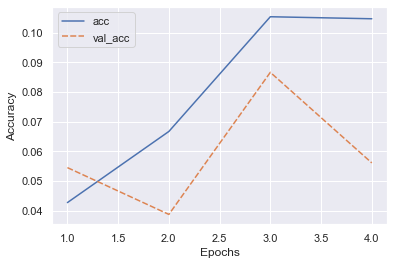

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

raw_data = pd.read_csv('DenseNet-CIFAR100-40-12-snapshot-1 training.csv')
raw_data = raw_data.drop(['Unnamed: 0', 'Unnamed: 1', 'lr', 'val_loss', 'loss'], axis=1)
raw_data.index += 1
print(raw_data.head())

sns.set_theme()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
sns.lineplot(data=raw_data)

## Ensemble snapshots and produce results 'over_time'


In [12]:
import sys
sys.path.append("../..")
from models import dense_net as DN

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

In [22]:
(trainX, trainY), (testX, testY) = cifar100.load_data()
nb_classes = len(np.unique(testY))

trainX = trainX.astype('float32')
trainX /= 255.0
testX = testX.astype('float32')
testX /= 255.0

trainY = kutils.to_categorical(trainY)
testY_cat = kutils.to_categorical(testY)

NUM_TESTS=25

In [23]:
dense_net_model = DN.create_dense_net(nb_classes=100, img_dim=(32, 32, 3), depth=40, nb_dense_block=1,
                                growth_rate=12, nb_filter=16, dropout_rate=0.2)

n_batches = 2
file_list =[f'DenseNet-CIFAR100-40-12-snapshot-{j}-1.h5' for j in range(n_batches)]

preds = []
for fn in file_list:
    dense_net_model.load_weights(fn)
    yPreds = dense_net_model.predict(testX, batch_size=128)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

DenseNet-40-12 created.
Obtained predictions from model with weights = DenseNet-CIFAR100-40-12-snapshot-0-1.h5
Obtained predictions from model with weights = DenseNet-CIFAR100-40-12-snapshot-1-1.h5


In [24]:
def calculate_weighted_accuracy(prediction_weights):
    weighted_predictions = np.zeros((testX.shape[0], nb_classes), dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = np.argmax(weighted_predictions, axis=1)
    yTrue = testY
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Accuracy : ", accuracy)
    print("Error : ", error)

In [25]:
# Create the loss metric
n_snapshots = 0
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((testX.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds[:n_snapshots]):
        final_prediction += weight * prediction

    return log_loss(testY_cat, final_prediction)

In [26]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):
        # Random initialization of weights
        prediction_weights = np.random.random(n_snapshots)
        
        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
        
        weights = result['x']
        weighted_predictions = np.zeros((testX.shape[0], nb_classes), dtype='float32')
        
        # Calculate weighted predictions
        for weight, prediction in zip(weights, preds[:n_snapshots]):
            weighted_predictions += weight * prediction

        yPred = np.argmax(weighted_predictions, axis=1)
        yTrue = testY

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        error = 100 - accuracy
        print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
        print("Iteration %d: Error : " % (iteration + 1), error)
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
            
        print()

        return accuracy

Best Ensemble Weights: [1.]
Iteration 1: Accuracy :  1.76
Iteration 1: Error :  98.24

Best Ensemble Weights: [0.87706663 0.12293337]
Iteration 1: Accuracy :  2.42
Iteration 1: Error :  97.58



<AxesSubplot:>

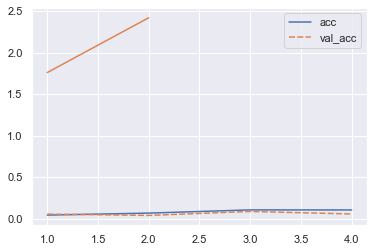

In [35]:
results = []
for i in range(1, n_batches + 1):
    # Compile list of units
    n_snapshots = i
    results.append(get_accuracy_for_n_snapshots(i))
    
sns.lineplot(data=raw_data)
sns.lineplot(x=np.arange(1, len(results) + 1), y=results)